### Loading Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
from sklearn.metrics import (ConfusionMatrixDisplay, auc, brier_score_loss,
                             classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.utils import class_weight
from xgboost import XGBClassifier

In [2]:
RANDOM_SEED = 5654717
TEST_WEEK = 9
DATA_DIR = "data/ball_carrier_data.csv"

pd.options.display.max_columns = None

### Loading Data

In [3]:
data = pd.read_csv(DATA_DIR, encoding='utf-8')
player_play = pd.read_csv('data/player_play.csv')

In [4]:
features = [
    'voronoi_area', 'distance_to_qb', 'distance_to_ball', 'defender_influence',
    'teammate_influence', 'defender_awareness', 'teammate_awareness',
    'qb_awareness', 'closest_defender_awareness', 'second_closest_defender_awareness', 
    'closest_teammate_awareness', 'second_closest_teammate_awareness', 
    'closest_defender_distance', 'second_closest_defender_distance', 
    'closest_defender_speed', 'second_closest_defender_speed', 
    'closest_teammate_distance', 'second_closest_teammate_distance', 
    'closest_teammate_speed', 'second_closest_teammate_speed', 'player_speed',
    'relative_x_speed_to_closest_defender', 'relative_x_speed_to_second_closest_defender',
    'relative_y_speed_to_closest_defender', 'relative_y_speed_to_second_closest_defender',
    'relative_x_speed_to_closest_teammate', 'relative_x_speed_to_second_closest_teammate',
    'relative_y_speed_to_closest_teammate', 'relative_y_speed_to_second_closest_teammate', 
    'distance_to_los', 'y_position',
    ]
target = 'isBallCarrier'

In [5]:
training_data = data[(data.week != TEST_WEEK)]
testing_data = data[(data.week == TEST_WEEK)]

X_train, y_train = training_data[features], training_data[target]
X_test, y_test = testing_data[features], testing_data[target]

In [6]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

### Scoring Function

In [7]:
def score_model(y_true, y_pred, y_prob):
    print(f'ROC AUC Score: {roc_auc_score(y_true=y_true, y_score=y_prob)}')
    print(f"Brier Score: {brier_score_loss(y_true=y_true, y_prob=y_prob)}")
    print('-'*20)
    print(f"Brier Score for Negative: {brier_score_loss(y_true=y_true[y_true==0], y_prob=y_prob[y_true==0])}")
    print(f"Brier Score for Positive: {brier_score_loss(y_true=y_true[y_true==1], y_prob=y_prob[y_true==1])}")
    print('-'*20)
    print(classification_report(y_true=y_true, y_pred=y_pred))
    print('-'*20)
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### XGBoost Classifier

ROC AUC Score: 0.8755789910070668
Brier Score: 0.1555105527935796
--------------------
Brier Score for Negative: 0.1589348057507378
Brier Score for Positive: 0.11876335396087984
--------------------


c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.70      0.82    530638
           1       0.21      0.85      0.34     49447

    accuracy                           0.71    580085
   macro avg       0.60      0.78      0.58    580085
weighted avg       0.91      0.71      0.78    580085

--------------------
Confusion Matrix:


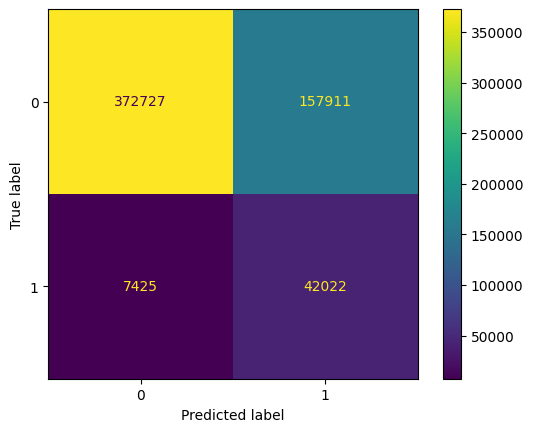

In [8]:
params = {
    "n_estimators": 250,
    "gamma": 100,
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "eta": 0.3,
    "subsample": 0.75,
    "max_depth": 5
}

xgb_classifier = XGBClassifier(random_state=RANDOM_SEED, **params)
xgb_classifier.fit(X_train, y_train, sample_weight=classes_weights)

y_pred_xgb = xgb_classifier.predict(X_test)
y_probs_xgb = xgb_classifier.predict_proba(X_test)

score_model(y_pred=y_pred_xgb, y_true=y_test, y_prob=y_probs_xgb[:, 1])

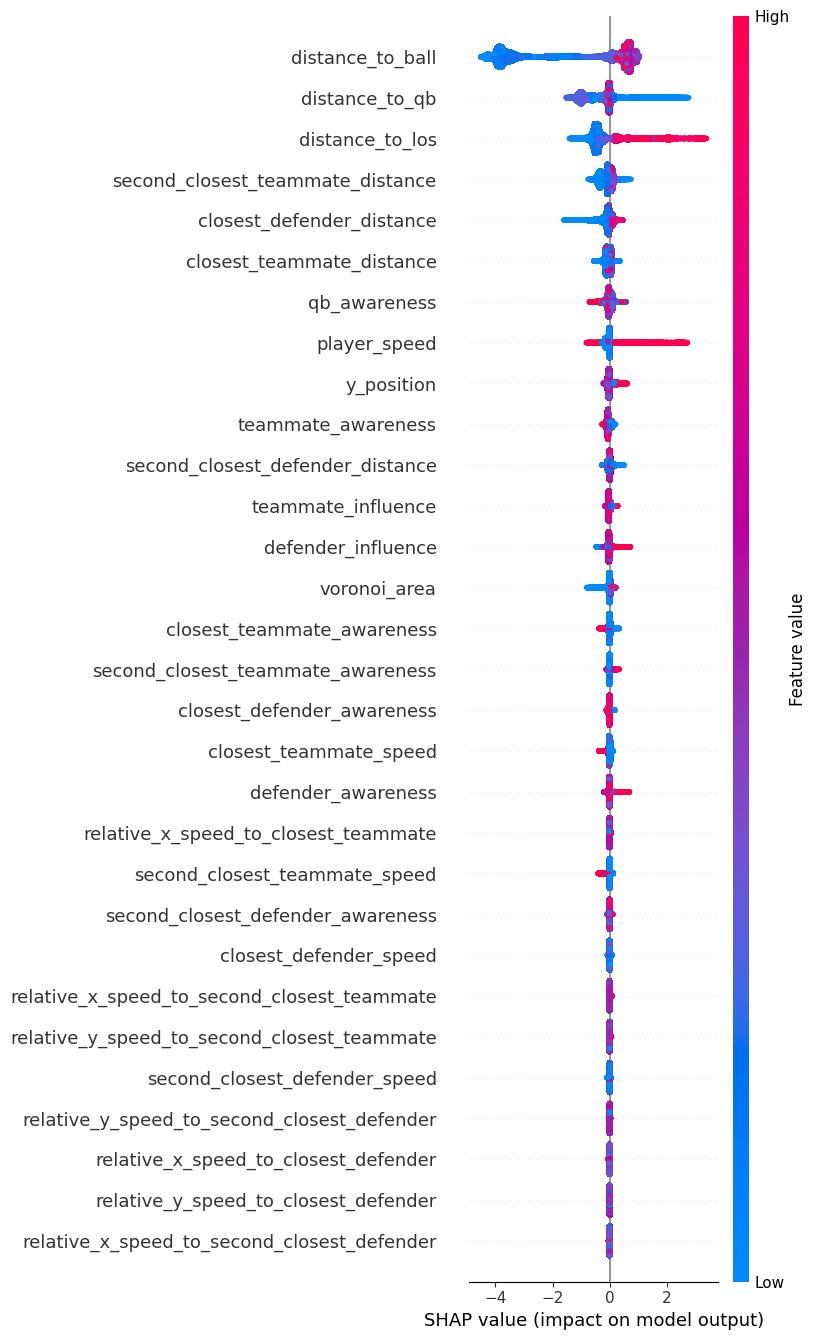

In [9]:
# Create an explainer object
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for a specific dataset
shap_values = explainer(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, max_display=30)

In [10]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_train.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
top_10_features = feature_importance.head(10).col_name.tolist()
feature_importance.head(10)

,col_name,feature_importance_vals
2,distance_to_ball,2.025459
1,distance_to_qb,0.505340
29,distance_to_los,0.503558
17,second_closest_teammate_distance,0.172502
12,closest_defender_distance,0.117287
16,closest_teammate_distance,0.082533
7,qb_awareness,0.079882
20,player_speed,0.070685
30,y_position,0.068407
6,teammate_awareness,0.062725


ROC AUC Score: 0.8733340864159755
Brier Score: 0.15463067770239064
--------------------
Brier Score for Negative: 0.15761054866889512
Brier Score for Positive: 0.12265234191004903
--------------------


c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
c:\Users\Simeel\NFL-Data-Bowl-2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:3239: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.70      0.82    530638
           1       0.21      0.85      0.34     49447

    accuracy                           0.72    580085
   macro avg       0.60      0.78      0.58    580085
weighted avg       0.91      0.72      0.78    580085

--------------------
Confusion Matrix:


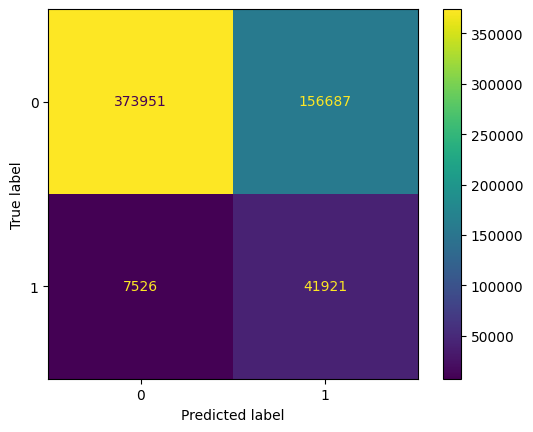

In [11]:
params = {
    "n_estimators": 250,
    "gamma": 150,
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "eta": 0.3,
    "subsample": 0.75,
    "max_depth": 9
}

xgb_classifier_pruned = XGBClassifier(random_state=RANDOM_SEED, **params)
xgb_classifier_pruned.fit(X_train[top_10_features], y_train, sample_weight=classes_weights)

y_pred_xgb = xgb_classifier_pruned.predict(X_test[top_10_features])
y_probs_xgb = xgb_classifier_pruned.predict_proba(X_test[top_10_features])

score_model(y_pred=y_pred_xgb, y_true=y_test, y_prob=y_probs_xgb[:, 1])

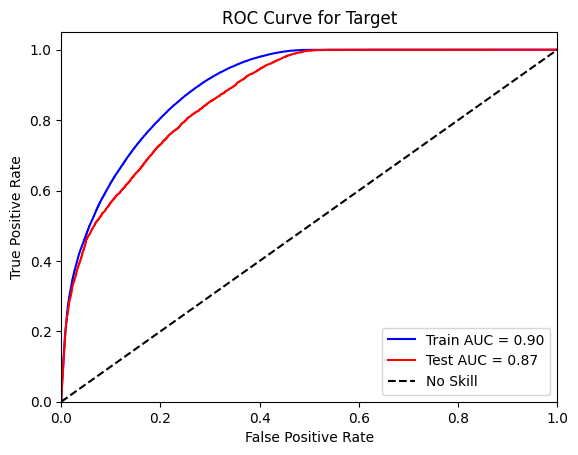

In [12]:
# Calculate ROC curve for train & test data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, xgb_classifier_pruned.predict_proba(X_train[top_10_features])[:, 1]) 
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_xgb[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure()  
plt.plot(fpr_train, tpr_train, label='Train AUC = %0.2f' % roc_auc_train, color = 'blue')
plt.plot(fpr_test, tpr_test, label='Test AUC = %0.2f' % roc_auc_test, color = 'red')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Target')
plt.legend()
plt.show()

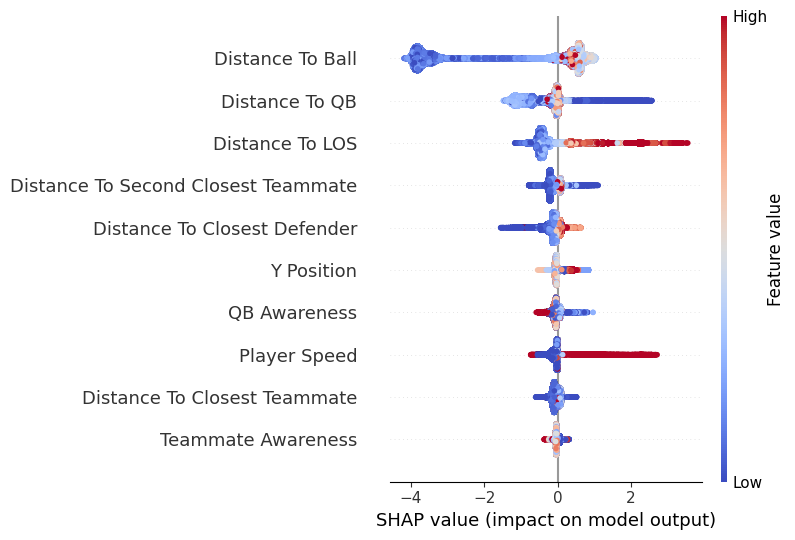

In [13]:
feature_names_cleaned = ['Distance To Ball', 'Distance To QB', 'Distance To LOS', 'Distance To Second Closest Teammate', 'Distance To Closest Defender', 'Distance To Closest Teammate', 'QB Awareness', 'Player Speed', 'Y Position', 'Teammate Awareness']

# Create an explainer object
explainer = shap.Explainer(xgb_classifier_pruned)

# Calculate SHAP values for a specific dataset
shap_values = explainer(X_test[top_10_features])

# Visualize SHAP values
shap.summary_plot(shap_values, X_test[top_10_features], feature_names=feature_names_cleaned, max_display=10, cmap='coolwarm')

In [14]:
# Save XGB model
xgb_classifier_pruned.save_model("models/potential_ball_carrier_predictor.json")